# Malware image classifier with ResNet101(CNN)


**Goal**: As malware attacks escalate, the accurate identification and classification of
malware samples are essential for effective countermeasures. Manual analysis
is time-consuming and impractical for large datasets. Our project focuses on
building a CNN model for multiclass classification of malware from the Malimg
Dataset, addressing the need for scalable and efficient solutions.

In [ ]:
#cd /content/gdrive/MyDrive/Colab_Notebooks/COEN396_Project

In [ ]:
# !unzip malimg_dataset.zip -d /content/gdrive/MyDrive/Colab_Notebooks/COEN396_Project/malimgData

In [1]:
pip install split-folders

Note: you may need to restart the kernel to use updated packages.


# Import Libraries

In [3]:
import sys
import os
import re
import cv2
from math import log
import numpy as np
import scipy as sp
from PIL import Image
import matplotlib.pyplot as plt
import splitfolders
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.utils import class_weight 
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet101
from keras.callbacks import ModelCheckpoint, EarlyStopping

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

**No need to run this cell, as we have already uploaded images in normal folder**

In [ ]:
# Specify the path to save the images
# save_path = "/content/gdrive/MyDrive/Colab_Notebooks/COEN396_Project/malimgData/malimg_paper_dataset_imgs/Normal"

# # Specify the number of images to generate
# num_images = 700

# # Specify image properties
# image_format = "PNG"
# image_mode = "L"
# image_size = (256, 346)
# min_pixel_value = 0
# max_pixel_value = 255
# mean_pixel_value = 121.93363890895954

# # Create the save directory if it doesn't exist
# if not os.path.exists(save_path):
#     os.makedirs(save_path)

# for i in range(num_images):
#     # Create a new image with the specified properties
#     pixels = np.random.randint(low=min_pixel_value, high=max_pixel_value+1, size=image_size, dtype=np.uint8)
#     image = Image.fromarray(pixels, mode=image_mode)

#     # Save the image
#     image_path = os.path.join(save_path, f"normal_image_{i+1}.png")
#     image.save(image_path)

# Split dataset: Train/Val/Test

In [3]:
#set ratios to split the data
input_folder = '/kaggle/input/malimg-with-normal-class/malimg_paper_dataset_imgs'
output_folder = 'dataset'
splitfolders.ratio(input_folder, output_folder, seed=1337, ratio=(0.8, 0.1, 0.1)) 

Copying files: 9898 files [00:54, 182.33 files/s]


In [4]:
from keras.preprocessing.image import ImageDataGenerator
#set the image size to 150
img_size = 150

#set the training data
train = ImageDataGenerator().flow_from_directory(directory='dataset/train', target_size=(img_size,img_size), batch_size=10000)

#set the validation data
val = ImageDataGenerator().flow_from_directory(directory='dataset/val', target_size=(img_size,img_size), batch_size=10000)

#set the testing data
test = ImageDataGenerator().flow_from_directory(directory='dataset/test', target_size=(img_size,img_size), batch_size=10000)

Found 7907 images belonging to 26 classes.
Found 977 images belonging to 26 classes.
Found 1014 images belonging to 26 classes.


In [5]:
train.class_indices

{'Adialer.C': 0,
 'Agent.FYI': 1,
 'Allaple.A': 2,
 'Allaple.L': 3,
 'Alueron.gen!J': 4,
 'Autorun.K': 5,
 'C2LOP.P': 6,
 'C2LOP.gen!g': 7,
 'Dialplatform.B': 8,
 'Dontovo.A': 9,
 'Fakerean': 10,
 'Instantaccess': 11,
 'Lolyda.AA1': 12,
 'Lolyda.AA2': 13,
 'Lolyda.AA3': 14,
 'Lolyda.AT': 15,
 'Malex.gen!J': 16,
 'Normal': 17,
 'Obfuscator.AD': 18,
 'Rbot!gen': 19,
 'Skintrim.N': 20,
 'Swizzor.gen!E': 21,
 'Swizzor.gen!I': 22,
 'VB.AT': 23,
 'Wintrim.BX': 24,
 'Yuner.A': 25}

In [6]:
d = train.class_indices

In [7]:
#show train classes keys
d.keys()

dict_keys(['Adialer.C', 'Agent.FYI', 'Allaple.A', 'Allaple.L', 'Alueron.gen!J', 'Autorun.K', 'C2LOP.P', 'C2LOP.gen!g', 'Dialplatform.B', 'Dontovo.A', 'Fakerean', 'Instantaccess', 'Lolyda.AA1', 'Lolyda.AA2', 'Lolyda.AA3', 'Lolyda.AT', 'Malex.gen!J', 'Normal', 'Obfuscator.AD', 'Rbot!gen', 'Skintrim.N', 'Swizzor.gen!E', 'Swizzor.gen!I', 'VB.AT', 'Wintrim.BX', 'Yuner.A'])

In [8]:
#load train images data and labels
imgs_train, labels_train = next(train)

#load validation images data and labels
imgs_val, labels_val = next(val)

In [9]:
#print the shape of training data
imgs_train.shape

(7907, 150, 150, 3)

In [10]:
#print the shape of training data lqbels
labels_train.shape

(7907, 26)

# Plot code to visualize some images from the train dataset

In [4]:
def plots(ims, figsize=(20,30), rows=10, interp=False, titles=None):
  
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = 10 # len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1

    #to show images 
    for i in range(0,50):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(list(train.class_indices.keys())[np.argmax(titles[i])], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

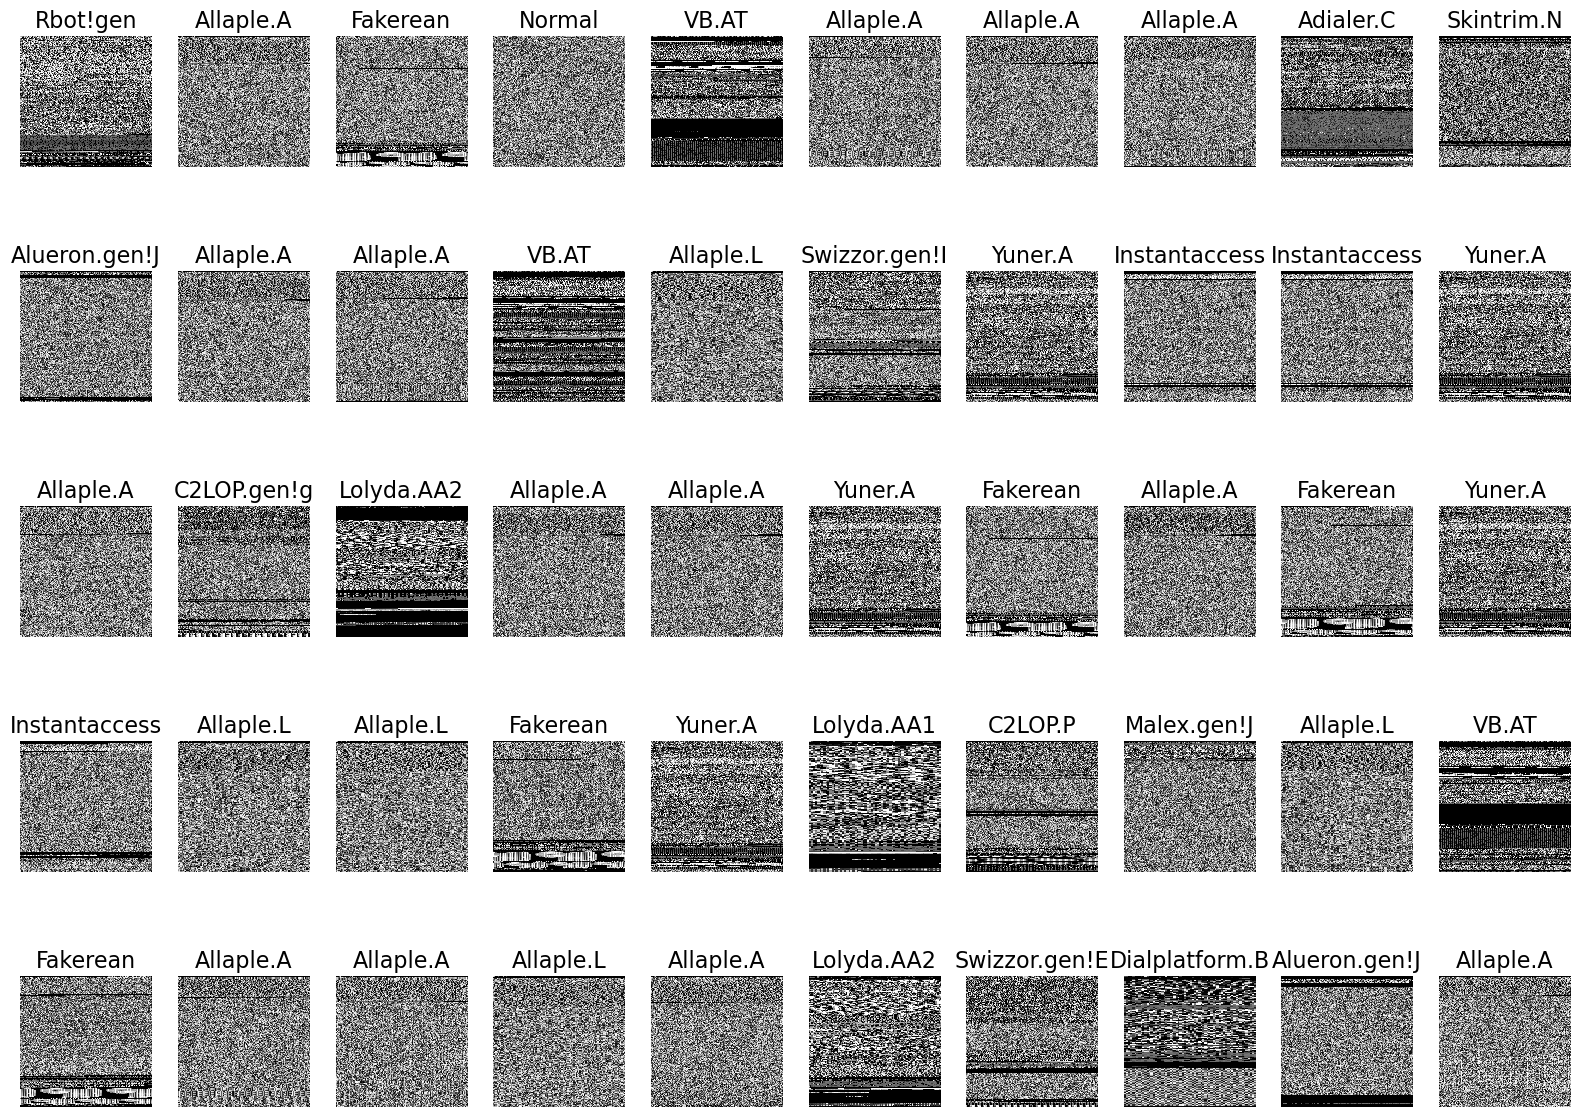

In [12]:
#show the images and their labels
plots(imgs_train, titles = labels_train)

<BarContainer object of 26 artists>

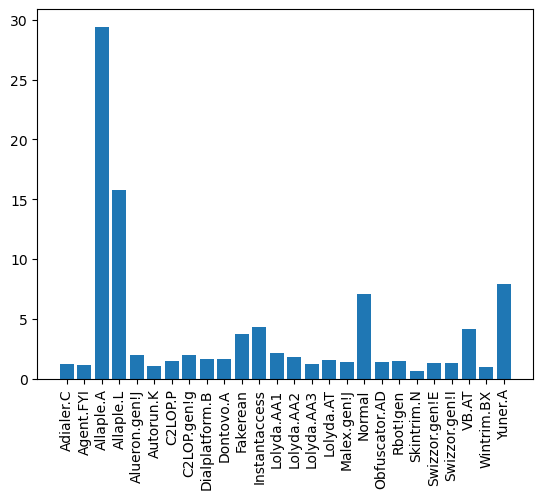

In [13]:
#to print the classes percentage distributions 
classes = train.class_indices.keys()
perc = (sum(labels_train)/labels_train.shape[0])*100

#show the gragh
plt.xticks(rotation='vertical')
plt.bar(classes,perc)

In [14]:
y_train_new = np.argmax(labels_train, axis=1)
y_train_new

array([19,  2, 10, ..., 12, 11,  2])

# Handling imbalance classes using class_weight

In [15]:
class_weights = class_weight.compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(y_train_new),
                                        y = y_train_new                                                    
                                    )

class_weights = dict(zip(np.unique(y_train_new), y_train_new))
class_weights

{0: 19,
 1: 2,
 2: 10,
 3: 17,
 4: 23,
 5: 2,
 6: 2,
 7: 2,
 8: 0,
 9: 20,
 10: 4,
 11: 2,
 12: 2,
 13: 23,
 14: 3,
 15: 22,
 16: 25,
 17: 11,
 18: 11,
 19: 25,
 20: 2,
 21: 7,
 22: 13,
 23: 2,
 24: 2,
 25: 25}

# For plotting the confusion matrix

In [5]:
def confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )

    #to show the confusion matrix plot
    fig = plt.figure(figsize=figsize)

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")

    #set fontsize and style of confusion matrix
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)

    #set the titles of the confusion matrix
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Baseline Model

In [6]:
# Set the path to your malimg dataset
dataset_path = "/kaggle/input/malimg-with-normal-class/malimg_paper_dataset_imgs"

# Load the malimg dataset and extract features
images = []
labels = []

class_mapping = {}  # Map class names to labels

# Read images and labels
for class_label, class_name in enumerate(os.listdir(dataset_path)):
    class_path = os.path.join(dataset_path, class_name)
    if not os.path.isdir(class_path):  # Skip if the current item is not a directory
        continue
    
    class_mapping[class_label] = class_name
    
    for image_file in os.listdir(class_path):
        image_path = os.path.join(class_path, image_file)
        image = cv2.imread(image_path, 0)  # Load the image as grayscale
        image = cv2.resize(image, (64, 64))  # Resize the image to a consistent size
        images.append(image.flatten())  # Flatten the image into a feature vector
        labels.append(class_label)  # Assign the class label

# Convert the data to NumPy arrays
X_base = np.array(images)
y_base = np.array(labels)

# Split the dataset into training, validation, and testing sets
X_train_base, X_test_val, y_train_base, y_test_val = train_test_split(X_base, y_base, test_size=0.2, random_state=42)
X_test_base, X_val_base, y_test_base, y_val_base = train_test_split(X_test_val, y_test_val, test_size=0.5, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train_base = scaler.fit_transform(X_train_base)
X_val_base = scaler.transform(X_val_base)
X_test_base = scaler.transform(X_test_base)

In [ ]:
# Create a Logistic Regression classifier
lr_classifier = LogisticRegression(multi_class='auto', solver='lbfgs', max_iter=2000)

# Train the Logistic Regression classifier
#lr_classifier.fit(X_train_base, y_train_base)
train_accuracy = []
test_accuracy = []

for i in range(1, 2001):
    lr_classifier.fit(X_train_base, y_train_base)
    train_accuracy.append(lr_classifier.score(X_train_base, y_train_base))

In [19]:
# Make predictions on the validation set
y_pred_val_base = lr_classifier.predict(X_val_base)

# Calculate evaluation metrics for validation set
accuracy_val_base = metrics.accuracy_score(y_val_base, y_pred_val_base)
precision_val_base = metrics.precision_score(y_val_base, y_pred_val_base, average='weighted')
recall_val_base = metrics.recall_score(y_val_base, y_pred_val_base, average='weighted')
f1_score_val_base = metrics.f1_score(y_val_base, y_pred_val_base, average='weighted')
classification_report_val_base = metrics.classification_report(y_val_base, y_pred_val_base)

# Print the evaluation metrics for validation set
print("Validation Set:")
print("Accuracy:", accuracy_val_base)
print("Precision:", precision_val_base)
print("Recall:", recall_val_base)
print("F1-Score:", f1_score_val_base)
print("\nClassification Report:")
print(classification_report_val_base)

Validation Set:
Accuracy: 0.9686868686868687
Precision: 0.9683821282590482
Recall: 0.9686868686868687
F1-Score: 0.968251710025671

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.92      0.92        12
           1       0.71      0.71      0.71         7
           2       0.73      0.80      0.76        20
           3       1.00      1.00      1.00        10
           4       1.00      1.00      1.00        45
           5       1.00      1.00      1.00        15
           6       1.00      0.99      0.99       148
           7       0.98      0.96      0.97        56
           8       1.00      0.95      0.98        21
           9       1.00      0.91      0.95        23
          10       1.00      1.00      1.00        13
          11       1.00      1.00      1.00        12
          12       1.00      1.00      1.00         9
          13       1.00      1.00      1.00         5
          14       0.97      1.00  

In [20]:
# Make predictions on the test set
y_pred_test_base = lr_classifier.predict(X_test_base)
y_proba_test_base = lr_classifier.predict_proba(X_test_base)

# Calculate average precision score
average_precision = metrics.precision_score(y_test_base, y_pred_test_base, average='weighted')


# Calculate evaluation metrics for test set
accuracy_test_base = metrics.accuracy_score(y_test_base, y_pred_test_base)
precision_test_base = metrics.precision_score(y_test_base, y_pred_test_base, average='weighted')
recall_test_base = metrics.recall_score(y_test_base, y_pred_test_base, average='weighted')
f1_score_test_base = metrics.f1_score(y_test_base, y_pred_test_base, average='weighted')
classification_report_test_base = metrics.classification_report(y_test_base, y_pred_test_base)

# Print the evaluation metrics for test set
print("\nTest Set:")
print("Accuracy:", accuracy_test_base)
print("Precision:", precision_test_base)
print("Recall:", recall_test_base)
print("F1-Score:", f1_score_test_base)
print("\nClassification Report:")
print(classification_report_test_base)


Test Set:
Accuracy: 0.9747474747474747
Precision: 0.9754780107988663
Recall: 0.9747474747474747
F1-Score: 0.9746815943902476

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       0.92      1.00      0.96        12
           2       0.95      0.91      0.93        23
           3       1.00      1.00      1.00         9
           4       1.00      1.00      1.00        44
           5       1.00      1.00      1.00        12
           6       1.00      0.98      0.99       157
           7       1.00      1.00      1.00        44
           8       1.00      1.00      1.00        15
           9       1.00      1.00      1.00        23
          10       1.00      1.00      1.00        12
          11       1.00      1.00      1.00        17
          12       1.00      1.00      1.00        13
          13       1.00      1.00      1.00         6
          14       0.99      1.00      

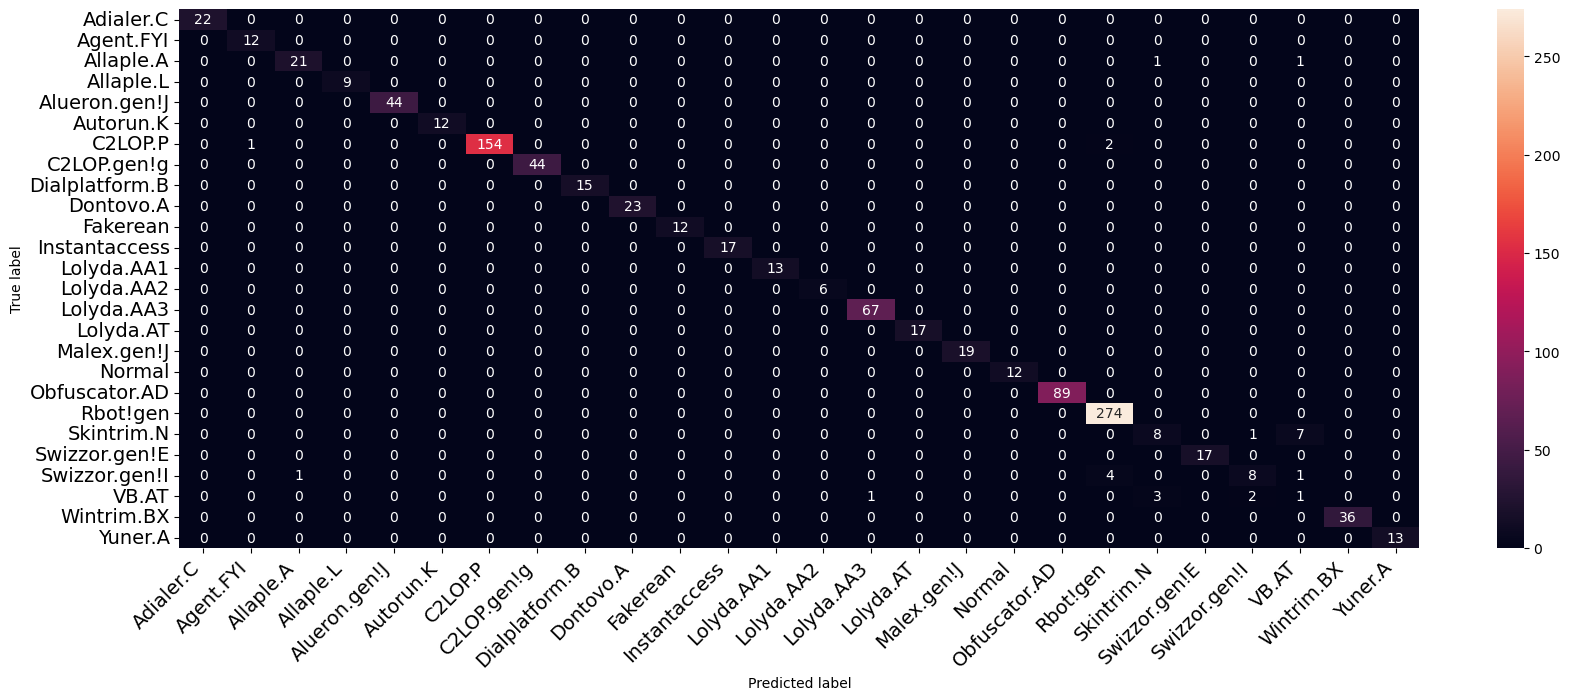

In [21]:
# Plot the confusion matrix
cm = metrics.confusion_matrix(y_test_base, y_pred_test_base)

#to print the confusion matrix
class_names= test.class_indices.keys()
confusion_matrix(cm, class_names, figsize = (20,7), fontsize=14)

# CNN: ResNet101 Model

In [22]:
#define a function for ResNet101 model
def malware_model_resNet():
    
    #build the model
    baseModel = ResNet101(weights="imagenet", include_top=False,input_shape=(img_size,img_size,3))

    #make the model as trainable
    for layer in baseModel.layers:
        layer.trainable = False  
     
    #build the model
    headModel = baseModel.output

    #set the maxpooling layer
    headModel = MaxPooling2D(pool_size=(2, 2))(headModel)

    #set a flatten layer
    headModel = Flatten(name="flatten")(headModel)

    #set the dense layer with relu activation
    headModel = Dense(256, activation="relu")(headModel)

    #set a dropout layer
    headModel = Dropout(0.5)(headModel)

    #set output layer with softmax activation function
    headModel = Dense(26, activation="softmax")(headModel)

    #build the model
    model = Model(inputs=baseModel.input, outputs=headModel)

    #compile the model using adam optimizer
    model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
    return model

In [23]:
Malware_model_ResNet = malware_model_resNet()

171446536/171446536 [==============================] - 2s 0us/step


In [24]:
Malware_model_ResNet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 156, 156, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 75, 75, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 75, 75, 64)   256         ['conv1_conv[0][0]']         

In [25]:
#for model check point 
checkpoint_filepath = 'ResNet_Checkpoints/'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

#for early stopping
model_early_stopping_callback=tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=5,
    verbose=0,
    mode="max",
)

#to fit the model
history = Malware_model_ResNet.fit(imgs_train, 
                            labels_train, 
                            validation_data=(imgs_val, labels_val), 
                            epochs=50,  
                            class_weight=class_weights,
                            callbacks=[model_checkpoint_callback,model_early_stopping_callback])

Malware_model_ResNet.load_weights(checkpoint_filepath)

#save the model
Malware_model_ResNet.save("ResNet_final.h5")

Epoch 1/50
248/248 [==============================] - 44s 117ms/step - loss: 7.3481 - accuracy: 0.7740 - val_loss: 0.5762 - val_accuracy: 0.9140
Epoch 2/50
248/248 [==============================] - 28s 112ms/step - loss: 1.9290 - accuracy: 0.8850 - val_loss: 0.7270 - val_accuracy: 0.9150
Epoch 3/50
248/248 [==============================] - 25s 103ms/step - loss: 1.5234 - accuracy: 0.8993 - val_loss: 0.6395 - val_accuracy: 0.9406
Epoch 4/50
248/248 [==============================] - 24s 99ms/step - loss: 1.2738 - accuracy: 0.9105 - val_loss: 0.6644 - val_accuracy: 0.9386
Epoch 5/50
248/248 [==============================] - 25s 99ms/step - loss: 1.1056 - accuracy: 0.9119 - val_loss: 0.5400 - val_accuracy: 0.9386
Epoch 6/50
248/248 [==============================] - 29s 115ms/step - loss: 1.1543 - accuracy: 0.9160 - val_loss: 0.6148 - val_accuracy: 0.9458
Epoch 7/50
248/248 [==============================] - 29s 116ms/step - loss: 0.9949 - accuracy: 0.9210 - val_loss: 0.5299 - val_accu

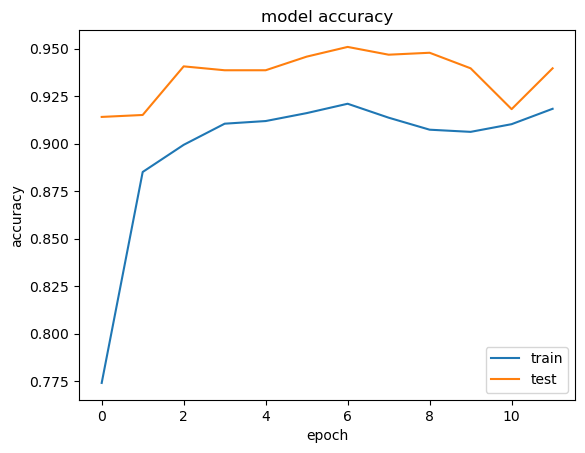

In [26]:
#print the accuracies curve
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

#set the titles of the plot
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

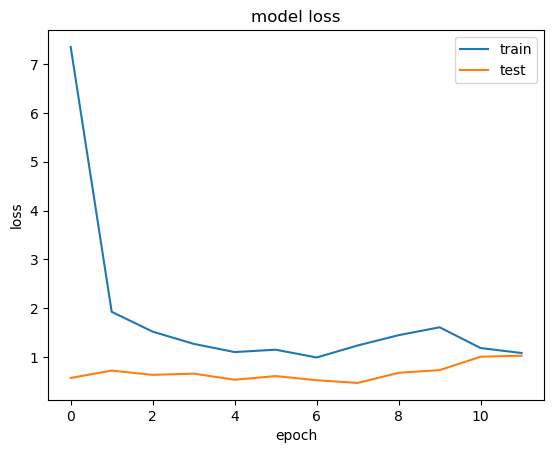

In [27]:
#print the model losses
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

#set the titles of the graph
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [28]:
scores = Malware_model_ResNet.evaluate(imgs_val, labels_val)

31/31 [==============================] - 3s 86ms/step - loss: 0.5299 - accuracy: 0.9509


In [29]:
#print the validation accuracy
print('Final ResNet101 accuracy on validation : ', scores[1])

Final ResNet101 accuracy on validation :  0.9508700370788574


In [30]:
#to calculate the testing accuracy
imgs_test, labels_test = next(test)

In [31]:
scores_test = Malware_model_ResNet.evaluate(imgs_test, labels_test)

32/32 [==============================] - 3s 105ms/step - loss: 0.5538 - accuracy: 0.9448


In [32]:
print('Final ResNet101 accuracy on Testing : ', scores_test[1])

Final ResNet101 accuracy on Testing :  0.9447731971740723


In [34]:
predict_x=Malware_model_ResNet.predict(imgs_test) 
y_pred=np.argmax(predict_x,axis=1)

32/32 [==============================] - 3s 82ms/step


In [35]:
y_test2 = np.argmax(labels_test, axis=1)

In [36]:
c_matrix = metrics.confusion_matrix(y_test2, y_pred)

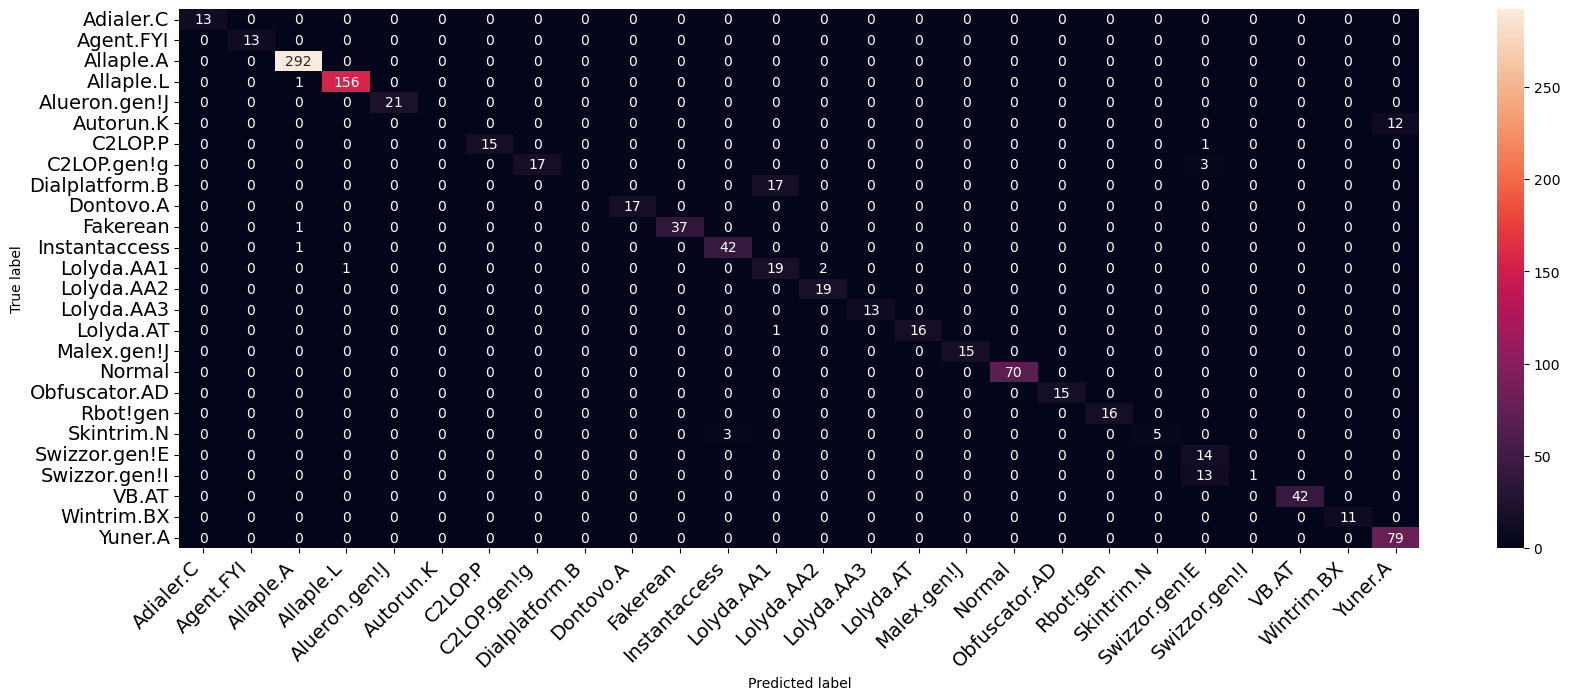

In [37]:
#to print the confusion matrix
class_names= test.class_indices.keys()
confusion_matrix(c_matrix, class_names, figsize = (20,7), fontsize=14)

# Convert bytes to images and test against model for predicting the malware class

files: ['0ACDbR5M3ZhBJajygTuf.bytes', '0A32eTdBKayjCWhZqDOQ.bytes']
Processing 0ACDbR5M3ZhBJajygTuf.bytes
Processing 0A32eTdBKayjCWhZqDOQ.bytes


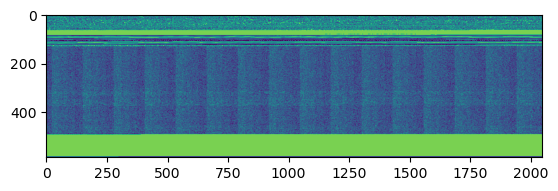

In [6]:
# Load the CSV file
csv_path = '/kaggle/input/malware-bytes-raw-data/dataRaw'

import os
from math import log
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def convertAndSave(array, name):
    print('Processing ' + name)
    if array.shape[1] != 16:  # If not hexadecimal
        assert False
    b = int((array.shape[0] * 16) ** (0.5))
    b = 2 ** (int(log(b) / log(2)) + 1)
    a = int(array.shape[0] * 16 / b)
    array = array[:a * b // 16, :]
    array = np.reshape(array, (a, b))
    im = Image.fromarray(np.uint8(array))
    save_path = "/kaggle/working/" + name + ".png"
    im.save(save_path, "PNG")
    return im

# Get the list of files
files = os.listdir(csv_path)
print('files:', files)
# We will process files one by one.
for counter, name in enumerate(files):
    # We only process .bytes files from our folder.
    if '.bytes' != name[-6:]:
        continue
    f = open(csv_path + '/' + name)
    array = []
    for line in f:
        xx = line.split()
        if len(xx) != 17:
            continue
        array.append([int(i, 16) if i != '??' else 0 for i in xx[1:]])
    plt.imshow(convertAndSave(np.array(array), name))
    del array
    f.close()


# Prediting malware class on test image: ResNet

In [41]:
# path='/content/normalImage.png'
# path = '/kaggle/input/test-images-posttraining/dataImages/dataImages_0ACDbR5M3ZhBJajygTuf.bytes.png'
path= '/kaggle/input/test-images-posttraining/dataImages/normal_image_2.png'
img = tf.keras.utils.load_img(path, target_size=(150, 150))
x = tf.keras.utils.img_to_array(img)
x = np.expand_dims(x, axis=0) 
classes = Malware_model_ResNet.predict(x)
classes = np.argmax(classes)

#set the images labels
label = list(d.keys())
print(label[classes])

1/1 [==============================] - 0s 29ms/step
Normal


In [1]:
# path='/content/normalImage.png'
path = '/kaggle/input/test-images-posttraining/dataImages/dataImages_0A32eTdBKayjCWhZqDOQ.bytes.png'
# path= '/kaggle/working/0ACDbR5M3ZhBJajygTuf.bytes.png'
# Load and preprocess the image
img = tf.keras.utils.load_img(image_path, target_size=(64, 64), color_mode="grayscale")
x_baseline = tf.keras.utils.img_to_array(img)
x_baseline = x_baseline.reshape(1, -1)  # Reshape to 1D array

# Feature scaling
scaler = StandardScaler()
x_baseline = scaler.fit_transform(x_baseline)

# Make predictions using the logistic regression model
y_pred_baseline = lr_classifier.predict(x_baseline)
class_label = y_pred_baseline[0]

# Get the corresponding class name from the mapping
class_name = class_mapping[class_label]

# Print the predicted class name
print("Predicted class:", class_name)

NameError: name 'tf' is not defined